# Simulation of a baseband signal modulated onto an intermediate frequency

In this simulation a signal is generated in the complex baseband and further it is subsequently modulated onto a carrier on an intermediate frequency.

The channel emulates amplitude noise with adjustable signal to noise ratio (SNR) and phase noise with adjustable linewidth.

At the receiver, the signal is downconverted into the baseband and filtered with a matched filter. After decimation an additional carrier phase estimation and synchronization routine is applied, before quality metricies like EVM and BER are determined. 

## Load needed packages.

In [2]:
import numpy as np
import scipy.signal as ssignal
try:
    # if you installed skcomm with pypi
    import skcomm  as skc
except:
    # if you like to use skcomm directly from source.
    # Please note: If you want to import skcomm into your file using this snippet, you must ensure that the file is on a directional level below skcomm.
    import sys, os
    current_parent_folder = os.path.abspath('..')
    sys.path.append(os.path.join(current_parent_folder))
    import skcomm as skc

## Set parameters.

In [3]:
# simulation parameters
linewidth = 1*600 # [Hz]
snr = 20
symbol_rate = 50e6
n_bits = 2**12
f_if_nom = 30e6

## Transmitter subsystem.

In [4]:

# construct signal
sig_tx = skc.signal.Signal(n_dims=1)
sig_tx.symbol_rate = 50e6 

# generate bits
sig_tx.generate_bits(n_bits=2**12, seed=1)

# set constellation (modulation format)
sig_tx.generate_constellation(format='QAM', order=4)

# create symbols
sig_tx.mapper()

# upsampling and pulseshaping
roll_off = 0.1
upsampling = 5
sig_tx.pulseshaper(upsampling=upsampling, pulseshape='rrc', roll_off=[roll_off])

# generate DAC samples (analytical signal at IF)
f_granularity = 1 / sig_tx.samples[0].size * sig_tx.sample_rate[0]
f_if = round(f_if_nom / f_granularity) * f_granularity
print('intermediate frequency: {} MHz'.format(f_if/1e6))
t = np.arange(0, np.size(sig_tx.samples[0])) / sig_tx.sample_rate

# upmixing to IF
sig_tx.samples[0] = sig_tx.samples[0] * np.exp(1j * 2 * np.pi * f_if * t)
sig_tx.center_frequency = f_if

intermediate frequency: 30.0048828125 MHz


## Emulate channel (delay, amplitude and phase noise)

In [5]:
samples = sig_tx.samples[0] 

# repeat rx sequence
sps = int(sig_tx.sample_rate[0] / sig_tx.symbol_rate[0])
ext = 40000*sps + 4000*sps
ratio_base = ext // samples.size
ratio_rem = ext % samples.size        
samples = np.concatenate((np.tile(samples, ratio_base), samples[:ratio_rem]), axis=0)

# add artificial delay 
delay = 10*sps
samples = samples[delay:]

## add amplitude noise
samples = skc.channel.set_snr(samples, snr_dB=snr, sps=int(sig_tx.sample_rate[0]/sig_tx.symbol_rate[0]), seed=None)

## phase noise emulation
samples = skc.channel.add_phase_noise(samples ,sig_tx.sample_rate[0] , linewidth, seed=1)['samples']
sr = sig_tx.sample_rate[0]

# after heterodyne detection and balanced detection
samples = np.real(samples)

## Receiver subsystem.

Resampling, IQ downmixing, normalization

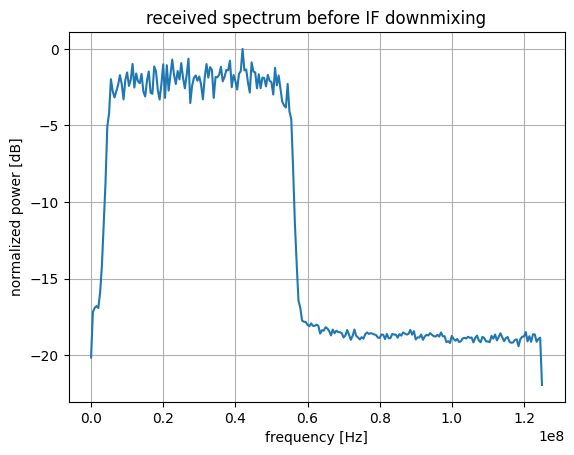

In [6]:
# construct rx signal structure
sig_rx = sig_tx.copy()
sig_rx.samples = samples
sig_rx.sample_rate = sr

# resampling to the same sample rate as at the transmitter
sr_dsp = sig_tx.sample_rate[0]

# watch out, that this is really an integer, otherwise the samplerate is asynchronous with the data afterwards!!!
len_dsp = sr_dsp / sig_rx.sample_rate[0] * np.size(samples)
if len_dsp % 1:
    raise ValueError('DSP samplerate results in asynchronous sampling of the data symbols')
sig_rx.samples = ssignal.resample(sig_rx.samples[0], num=int(len_dsp), window=None)
sig_rx.sample_rate = sr_dsp
sig_rx.plot_spectrum(tit='received spectrum before IF downmixing', resolution_bw=500e3)

# IQ-Downmixing 
t = skc.utils.create_time_axis(sig_rx.sample_rate[0], np.size(sig_rx.samples[0]))
samples_bb = samples *  np.exp(-1j*2*np.pi*(f_if+1e4*0)*t)
sig_rx.samples[0] = samples_bb

# resample to 2 sps
sps_new = 2
sps = sig_rx.sample_rate[0]/sig_rx.symbol_rate[0]
new_length = int(sig_rx.samples[0].size/sps*sps_new)
sig_rx.samples = ssignal.resample(sig_rx.samples[0], new_length, window='boxcar')
sig_rx.sample_rate = sps_new*sig_rx.symbol_rate[0]

# normalize samples to mean magnitude of original constellation
mag_const = np.mean(abs(sig_rx.constellation[0]))
mag_samples = np.mean(abs(sig_rx.samples[0]))
sig_rx.samples = sig_rx.samples[0] * mag_const / mag_samples

sig_rx.plot_constellation(hist=True, tit='constellation before EQ')


Matched filtering, timing recovery, decimation

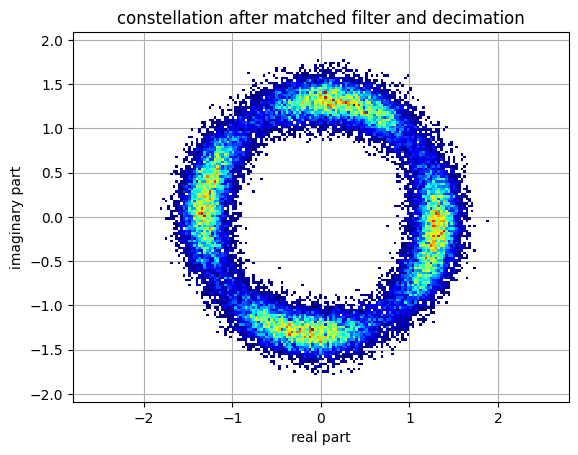

In [7]:
# Rx matched filter
sig_rx.raised_cosine_filter(roll_off=roll_off,root_raised=True) 

# crop samples here, if necessary
sps = int(sig_rx.sample_rate[0] / sig_rx.symbol_rate[0])
crop = 10*sps
if crop != 0:
    sig_rx.samples = sig_rx.samples[0][crop:-crop]
else:
    sig_rx.samples = sig_rx.samples[0]

# sampling phase adjustment
BLOCK_SIZE = -1 
sig_rx.sampling_clock_adjustment(BLOCK_SIZE)
    
# sampling (if necessary)
START_SAMPLE = 0
sps = sig_rx.sample_rate[0] / sig_rx.symbol_rate[0]
sig_rx.samples = sig_rx.samples[0][START_SAMPLE::int(sps)]

sig_rx.plot_constellation(0, hist=True, tit='constellation after matched filter and decimation')


Carrier phase estimation (CPE)

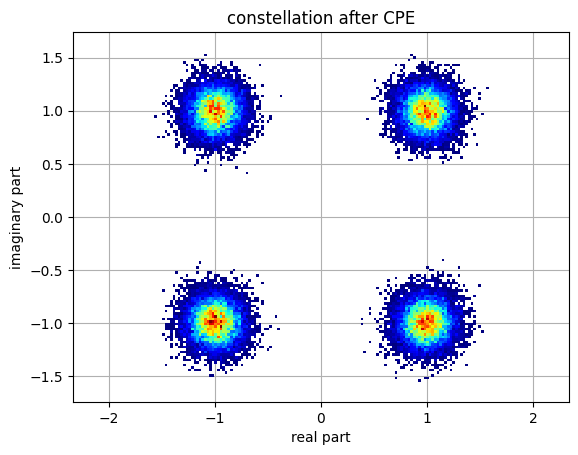

In [8]:

# CPE
cpe_results = skc.rx.carrier_phase_estimation_bps(sig_rx.samples[0], sig_rx.constellation[0], 
                                           n_taps=15, n_test_phases=15, const_symmetry=np.pi/2)

sig_rx.samples = cpe_results['samples_corrected']
est_phase = cpe_results['est_phase_noise']
    
skc.visualizer.plot_signal(est_phase, tit='estimated phase noise')
sig_rx.plot_constellation(hist=True, tit='constellation after CPE')

Synchronization, errror vector magnitude (EVM) determination and bit error rate (BER) calculation

In [9]:
# delay and phase ambiguity estimation and compensation
sig_rx = skc.rx.symbol_sequence_sync(sig_rx, dimension=-1)["sig"]
    
# calc EVM
evm = skc.utils.calc_evm(sig_rx, norm='max')
print("EVM: {:2.2%}".format(evm[0]))

# decision and demapper
sig_rx.decision()
sig_rx.demapper()

# BER counting
ber_res = skc.rx.count_errors(sig_rx.bits[0], sig_rx.samples[0])
print('BER = {}'.format(ber_res['ber']))

EVM: 14.29%
BER = 0.0
